/content/test1.png_out_t00.55_w0.95.jpg


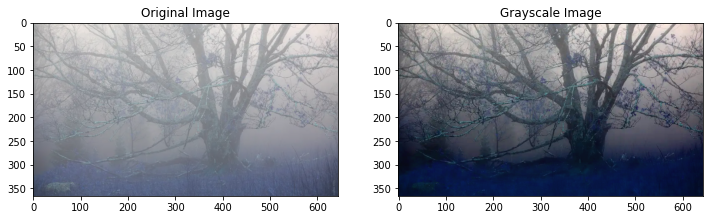

In [ ]:
 from __future__ import division
import cv2
import numpy as np


class Channel_value:
    val = -1.0
    intensity = -1.0


def find_intensity_of_atmospheric_light(img, gray):
    top_num = int(img.shape[0] * img.shape[1] * 0.001)
    toplist = [Channel_value()] * top_num
    dark_channel = find_dark_channel(img)

    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            val = img.item(y, x, dark_channel)
            intensity = gray.item(y, x)
            for t in toplist:
                if t.val < val or (t.val == val and t.intensity < intensity):
                    t.val = val
                    t.intensity = intensity
                    break

    max_channel = Channel_value()
    for t in toplist:
        if t.intensity > max_channel.intensity:
            max_channel = t

    return max_channel.intensity


def find_dark_channel(img):
    return np.unravel_index(np.argmin(img), img.shape)[2]


def clamp(minimum, x, maximum):
    return max(minimum, min(x, maximum))


def dehaze(img, light_intensity, windowSize, t0, w):
    size = (img.shape[0], img.shape[1])

    outimg = np.zeros(img.shape, img.dtype)

    for y in range(size[0]):
        for x in range(size[1]):
            x_low = max(x-(windowSize//2), 0)
            y_low = max(y-(windowSize//2), 0)
            x_high = min(x+(windowSize//2), size[1])
            y_high = min(y+(windowSize//2), size[0])

            sliceimg = img[y_low:y_high, x_low:x_high]

            dark_channel = find_dark_channel(sliceimg)
            t = 1.0 - (w * img.item(y, x, dark_channel) / light_intensity)

            outimg.itemset((y,x,0), clamp(0, ((img.item(y,x,0) - light_intensity) / max(t, t0) + light_intensity), 255))
            outimg.itemset((y,x,1), clamp(0, ((img.item(y,x,1) - light_intensity) / max(t, t0) + light_intensity), 255))
            outimg.itemset((y,x,2), clamp(0, ((img.item(y,x,2) - light_intensity) / max(t, t0) + light_intensity), 255))
    return outimg


def main():
    imageName = '/content/test1.png'  # eg. fg5.jpg
    img = cv2.imread(imageName)
    #cv2.namedWindow("result", cv2.CV_WINDOW_AUTOSIZE)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    light_intensity = find_intensity_of_atmospheric_light(img, gray)
    w = 0.95
    t0 = 0.55
    outimg = dehaze(img, light_intensity, 20, t0, w)
    name = imageName+'_out_t0'+str(t0)+'_w'+str(w)+'.jpg'
    print (name)

    plt.figure(figsize=(12,12))
    plt.subplot(121)
    plt.imshow(img);
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(outimg);
    plt.title("Grayscale Image");

    cv2.imwrite(name, outimg)

if __name__ == "__main__": main()

In [ ]:
from DepthMap_RTM import Depth_TM
from Saturation_Max import Sat_max
from depthMapEstimation import depthMap
from getGBTransmission import getGBTransmissionESt
from getRefinedTransmission import Refinedtransmission
from getTransmissionEstimation import getTransmission
from global_histogram_stretching import stretching
from sceneRadiance import sceneRadianceRGB


path = "/content/InputImages"
# path = "F:/PaperExperiments/ACMMM2018/OptimalTM_BLs_Restor/Temps"
files = os.listdir(path)
files =  natsort.natsorted(files)
starttime = datetime.datetime.now()

# BLs = read_xls_file()
# print('BLs',BLs)

for i in range(len(files)):
    file = files[i]
    Num  = file.split('.')[0]
    filepath = path + "/" + file
    # BL = BLs[i]
    print('********    file   ********', file)
    img = cv2.imread('InputImages/' + file)
    # img = cv2.imread('Temps/' + file)

    height = len(img)
    width = len(img[0])
    gimfiltR = 50  #
    eps = 10 ** -3  #
    blockSize = 9
    Nrer = [0.95, 0.93, 0.85]


    # cv2.imwrite('Results_Single_Channel/' + Num + 'Refined_transmissionR.jpg', np.uint8(img[:,:,2] ))
    # cv2.imwrite('Results_Single_Channel/' + Num + 'Refined_transmissionG.jpg', np.uint8(img[:,:,1] ))
    # cv2.imwrite('Results_Single_Channel/' + Num + 'Refined_transmissionB.jpg', np.uint8(img[:,:,0] ))

    AtomsphericLight = np.zeros(3)
    AtomsphericLight[0] = (1.13 * np.mean(img[:, :, 0])) + 1.11 * np.std(img[:, :, 0]) - 25.6
    AtomsphericLight[1] = (1.13 * np.mean(img[:, :, 1])) + 1.11 * np.std(img[:, :, 1]) - 25.6
    AtomsphericLight[2] = 140 / (1 + 14.4 * np.exp(-0.034 * np.median(img[:, :, 2])))
    AtomsphericLight = np.clip(AtomsphericLight, 10, 245)
    print('AtomsphericLight', AtomsphericLight)
    transmissionR = getTransmission(img, AtomsphericLight, blockSize)
    transmissionR_new = transmissionR
    TM_R_modified = Depth_TM(img, AtomsphericLight)
    # # TM_R_modified_Art = Sat_max(img)
    transmissionR_new = np.copy(transmissionR)
    #
    #for i in range(0, img.shape[0]):
     #    for j in range(0, img.shape[1]):
      #     if(transmissionR_new[i, j] > TM_R_modified[i, j]):
                 #print('transmissionR_new[i, j]', transmissionR_new[i, j])
                 #print('TM_R_modified[i, j]', TM_R_modified[i, j])
       #          transmissionR_new[i, j] = TM_R_modified[i, j]

    # for i in range(0, img.shape[0]):
    #     for j in range(0, img.shape[1]):
    #         if(transmissionR_new[i, j] > TM_R_modified[i, j]):
    #             # print('transmissionR_new[i, j]', transmissionR_new[i, j])
    #             # print('TM_R_modified[i, j]', TM_R_modified[i, j])
    #             transmissionR_new[i, j] = TM_R_modified[i, j]
    #         if(transmissionR_new[i, j] < TM_R_modified_Art[i, j]):
    #             transmissionR_new[i, j] = TM_R_modified_Art[i, j]



    #cv2.imwrite('Results_TMs/' + Num + 'TM_R_Refi_modified_fusion.jpg', np.uint8(transmissionR_new * 255))
    #transmissionR_Stretched = stretching(transmissionR_new, height, width)

    #cv2.imwrite('Results_TMs/' + Num + 'TM_R.jpg', np.uint8(transmissionR_Stretched * 255))

********    file   ******** test1.png
AtomsphericLight [187.12244576 186.56715175 131.49865146]


In [ ]:
plt.imshow(np.uint8(transmissionR_new * 255)[:,:,0])

In [ ]:
transmissionR_Stretched = stretching(transmissionR[:,:,0], height, width)

In [ ]:
transmissionB, transmissionG, depth_map = getGBTransmissionESt(transmissionR_Stretched, AtomsphericLight)

In [ ]:
transmission = Refinedtransmission(transmissionB,transmissionG,transmissionR_Stretched, img)

In [ ]:
transmissionR_Stretched = transmission[:, :, 2]

In [ ]:
sceneRadiance = sceneRadianceRGB(img, transmission, AtomsphericLight)

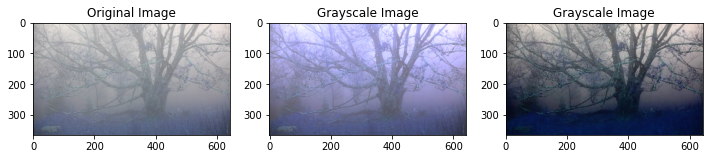

In [ ]:
img2 = cv2.imread('/content/test1.png_out_t00.55_w0.95.jpg')
plt.figure(figsize=(12,12))
plt.subplot(131)
plt.imshow(img);
plt.title("Original Image")
plt.subplot(132)
plt.imshow(sceneRadiance);
plt.title("Grayscale Image");
plt.subplot(133)
plt.imshow(img2);
plt.title("Grayscale Image");


In [ ]:
import natsort
import cv2
import numpy as np
import matplotlib.pyplot as plt

from GuidedFilter import GuidedFilter
from backgroundLight import BLEstimation
from depthMapEstimation import depthMap
from depthMin import minDepth
from getRGBTransmission import getRGBTransmissionESt
from global_Stretching import global_stretching
from refinedTransmissionMap import refinedtransmissionMap


from sceneRadiance import sceneRadianceRGB


In [ ]:
img = cv2.imread("/content/test5.png")

blockSize = 9
gimfiltR = 50
eps = 10 ** -3

DepthMap = depthMap(img)
DepthMap = global_stretching(DepthMap)
guided_filter = GuidedFilter(img, gimfiltR, eps)
refineDR = guided_filter.filter(DepthMap)
refineDR = np.clip(refineDR, 0,1)


In [ ]:
AtomsphericLight = BLEstimation(img, DepthMap) * 255

d_0 = minDepth(img, AtomsphericLight)
d_f = 4 * (DepthMap + d_0)
transmissionB, transmissionG, transmissionR = getRGBTransmissionESt(d_f)

transmission = refinedtransmissionMap(transmissionB, transmissionG, transmissionR, img)
sceneRadiance = sceneRadianceRGB(img, transmission, AtomsphericLight)

In [ ]:
print('AtomsphericLight',AtomsphericLight)


AtomsphericLight [ 3. 44. 18.]


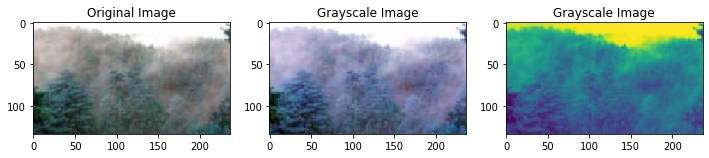

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(131)
plt.imshow(img);
plt.title("Original Image")
plt.subplot(132)
plt.imshow(sceneRadiance);
plt.title("Grayscale Image");
plt.subplot(133)
plt.imshow(np.uint8(transmission[:, :, 2] * 255));
plt.title("Grayscale Image");
